In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import calendar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm
import imageio
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
t2m_wf = xr.open_dataset('/nird/datalake/NS1004K/elihho/tes0004_echam6_BOT_mm_0_1850_var167.nc')
t2m_wof = xr.open_dataset('/nird/datalake/NS1004K/elihho/slo0059_echam6_BOT_mm_0_1850_var167.nc')

In [3]:
# For t2m_wf
n_months_wf = t2m_wf.sizes['time']
years_wf = np.floor_divide(np.arange(n_months_wf), 12)
months_wf = (np.remainder(np.arange(n_months_wf), 12) + 1)
cftime_time_wf = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wf, months_wf)]
t2m_wf = t2m_wf.assign_coords(time=("time", cftime_time_wf))

# For t2m_wof
n_months_wof = t2m_wof.sizes['time']
years_wof = np.floor_divide(np.arange(n_months_wof), 12)
months_wof = (np.remainder(np.arange(n_months_wof), 12) + 1)
cftime_time_wof = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wof, months_wof)]
t2m_wof = t2m_wof.assign_coords(time=("time", cftime_time_wof))

In [4]:
# Split seasons
t2m_wf_DJF = t2m_wf['var167'][0::4,:,:]
t2m_wf_JJA = t2m_wf['var167'][2::4,:,:]

t2m_wof_DJF = t2m_wof['var167'][0::4,:,:]
t2m_wof_JJA = t2m_wof['var167'][2::4,:,:]

In [5]:
start_year = 1250
end_year = 1850

In [6]:
t2m_wf_lia = t2m_wf.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
t2m_wof_lia = t2m_wof.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

In [7]:
# Simple average
global_mean_lia_wf = t2m_wf_lia['var167'].mean(dim=['lat', 'lon'])
global_mean_lia_wof = t2m_wof_lia['var167'].mean(dim=['lat', 'lon'])

rolling_years = 10
rolling_months = rolling_years * 12

smoothed_global_mean_wf = global_mean_lia_wf.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_wof = global_mean_lia_wof.rolling(time=rolling_months, center=True).mean()

In [8]:
scand_lat = slice(84, 50)
scand_lon = slice(-10, 50)

scand_lia_wf = t2m_wf_lia['var167'].sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])
scand_lia_wof = t2m_wof_lia['var167'].sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf = scand_lia_wf.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof = scand_lia_wof.rolling(time=rolling_months, center=True).mean()


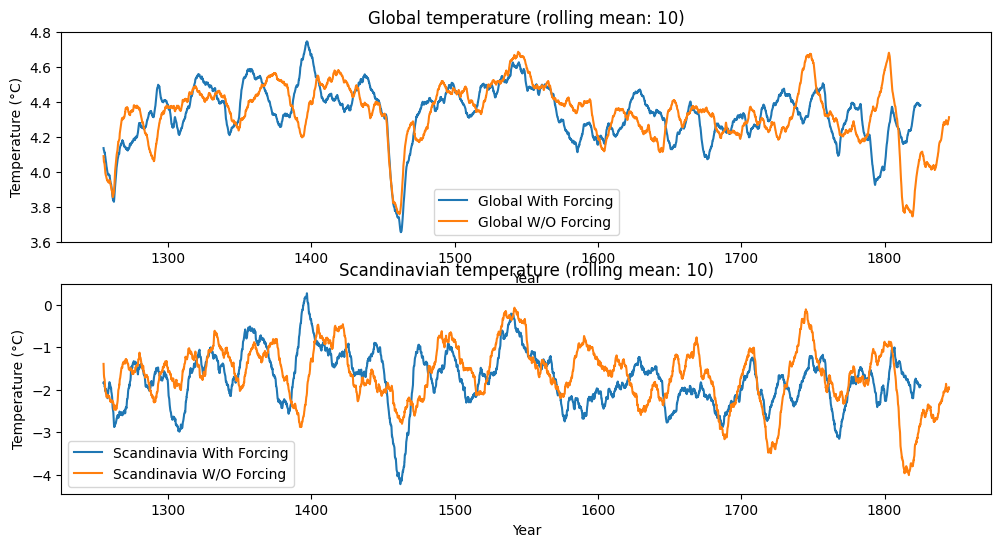

In [9]:
# Extract decimal years from cftime time coordinate
def cftime_to_decimal_year(time_array):
    years = np.array([t.year for t in time_array])
    months = np.array([t.month for t in time_array])
    # Approximate decimal year (month/12)
    decimal_years = years + (months - 1) / 12
    return decimal_years

x_wf = cftime_to_decimal_year(smoothed_global_mean_wf['time'].values)
x_wof = cftime_to_decimal_year(smoothed_global_mean_wof['time'].values)

x_scand_wf = cftime_to_decimal_year(scand_smoothed_wf['time'].values)
x_scand_wof = cftime_to_decimal_year(scand_smoothed_wof['time'].values)

fig, ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(x_wf, smoothed_global_mean_wf - 273.15, label='Global With Forcing')
ax[0].plot(x_wof, smoothed_global_mean_wof - 273.15, label='Global W/O Forcing')
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global temperature (rolling mean: {rolling_years})')

ax[1].plot(x_scand_wf, scand_smoothed_wf - 273.15, label='Scandinavia With Forcing')
ax[1].plot(x_scand_wof, scand_smoothed_wof - 273.15, label='Scandinavia W/O Forcing')
ax[1].legend()
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'Scandinavian temperature (rolling mean: {rolling_years})')

plt.tight_layout
plt.show()

In [10]:
t2m_wf_lia_DJF = t2m_wf_DJF.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
t2m_wof_lia_DJF = t2m_wof_DJF.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

In [11]:
# Simple average
global_mean_lia_wf_DJF = t2m_wf_lia_DJF.mean(dim=['lat', 'lon'])
global_mean_lia_wof_DJF = t2m_wof_lia_DJF.mean(dim=['lat', 'lon'])

smoothed_global_mean_wf_DJF = global_mean_lia_wf_DJF.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_wof_DJF = global_mean_lia_wof_DJF.rolling(time=rolling_months, center=True).mean()

In [12]:
scand_lia_wf_DJF = t2m_wf_lia_DJF.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])
scand_lia_wof_DJF = t2m_wof_lia_DJF.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf_DJF = scand_lia_wf_DJF.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof_DJF = scand_lia_wof_DJF.rolling(time=rolling_months, center=True).mean()

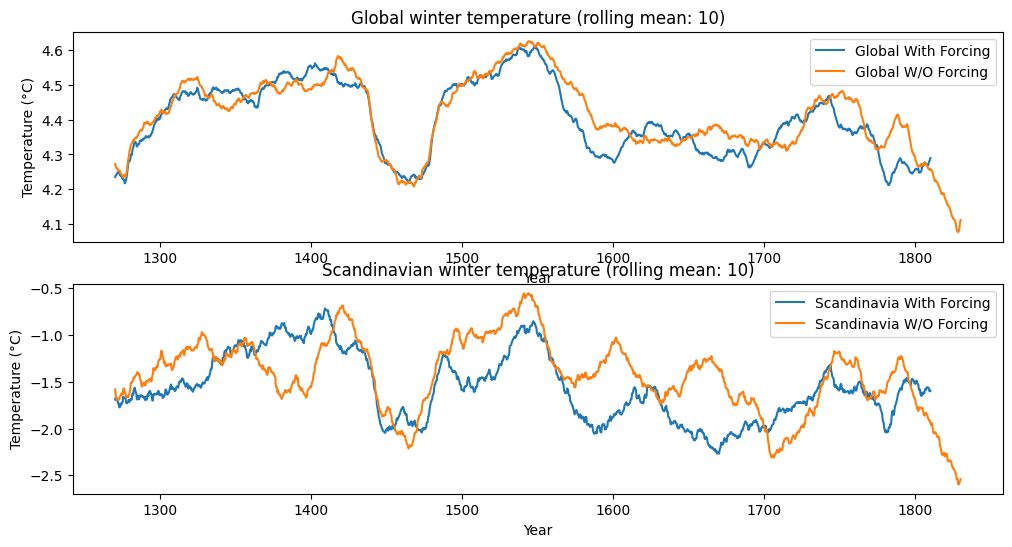

In [13]:
x_wf_DJF = cftime_to_decimal_year(smoothed_global_mean_wf_DJF['time'].values)
x_wof_DJF = cftime_to_decimal_year(smoothed_global_mean_wof_DJF['time'].values)

x_scand_wf_DJF = cftime_to_decimal_year(scand_smoothed_wf_DJF['time'].values)
x_scand_wof_DJF = cftime_to_decimal_year(scand_smoothed_wof_DJF['time'].values)

fig, ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(x_wf_DJF, smoothed_global_mean_wf_DJF - 273.15, label='Global With Forcing')
ax[0].plot(x_wof_DJF, smoothed_global_mean_wof_DJF - 273.15, label='Global W/O Forcing')
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global winter temperature (rolling mean: {rolling_years})')

ax[1].plot(x_scand_wf_DJF, scand_smoothed_wf_DJF - 273.15, label='Scandinavia With Forcing')
ax[1].plot(x_scand_wof_DJF, scand_smoothed_wof_DJF - 273.15, label='Scandinavia W/O Forcing')
ax[1].legend()
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'Scandinavian winter temperature (rolling mean: {rolling_years})')

plt.tight_layout
plt.show()

In [14]:
t2m_wf_lia_JJA = t2m_wf_JJA.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
t2m_wof_lia_JJA = t2m_wof_JJA.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

In [15]:
# Simple average
global_mean_lia_wf_JJA = t2m_wf_lia_JJA.mean(dim=['lat', 'lon'])
global_mean_lia_wof_JJA = t2m_wof_lia_JJA.mean(dim=['lat', 'lon'])

smoothed_global_mean_wf_JJA = global_mean_lia_wf_JJA.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_wof_JJA = global_mean_lia_wof_JJA.rolling(time=rolling_months, center=True).mean()

In [16]:
scand_lia_wf_JJA = t2m_wf_lia_JJA.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])
scand_lia_wof_JJA = t2m_wof_lia_JJA.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf_JJA = scand_lia_wf_JJA.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof_JJA = scand_lia_wof_JJA.rolling(time=rolling_months, center=True).mean()

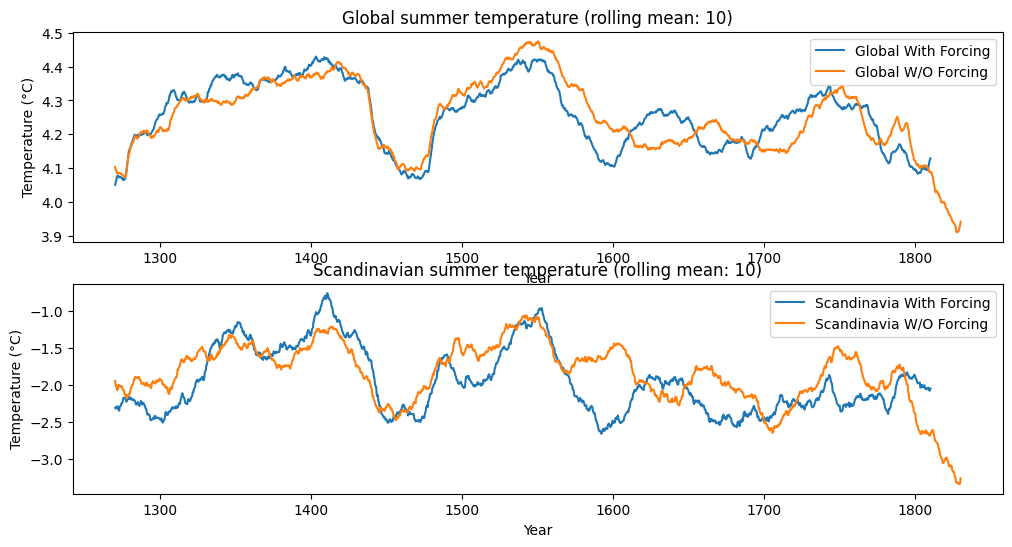

In [17]:
x_wf_JJA = cftime_to_decimal_year(smoothed_global_mean_wf_JJA['time'].values)
x_wof_JJA = cftime_to_decimal_year(smoothed_global_mean_wof_JJA['time'].values)

x_scand_wf_JJA = cftime_to_decimal_year(scand_smoothed_wf_JJA['time'].values)
x_scand_wof_JJA = cftime_to_decimal_year(scand_smoothed_wof_JJA['time'].values)

fig, ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(x_wf_JJA, smoothed_global_mean_wf_JJA - 273.15, label='Global With Forcing')
ax[0].plot(x_wof_JJA, smoothed_global_mean_wof_JJA - 273.15, label='Global W/O Forcing')
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global summer temperature (rolling mean: {rolling_years})')

ax[1].plot(x_scand_wf_JJA, scand_smoothed_wf_JJA - 273.15, label='Scandinavia With Forcing')
ax[1].plot(x_scand_wof_JJA, scand_smoothed_wof_JJA - 273.15, label='Scandinavia W/O Forcing')
ax[1].legend()
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'Scandinavian summer temperature (rolling mean: {rolling_years})')

plt.tight_layout
plt.show()